In [20]:
import os
import time
import math
import random
import itertools
import numpy as np
import osmnx as ox
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm

In [215]:
def download_graph(id, simplify=True):
    gdf = ox.geocode_to_gdf(id, by_osmid=True)
    polygon_boundary = gdf.unary_union
    graph = ox.graph_from_polygon(polygon_boundary,
                                  network_type='drive',
                                  simplify=simplify)
    G = nx.Graph(graph)
    H = nx.Graph()
    # Добавляем рёбра в новый граф, копируя только веса
    for u, d in G.nodes(data=True):
        H.add_node(u, x=d['x'], y=d['y'])
    for u, v, d in G.edges(data=True):
        H.add_edge(u, v, length=d['length'])

    
    # Создание папки, если она не существует
    directory = "data\graphs"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Запись графа в файл GraphML
    file_path = os.path.join(directory, f"graph_{id}.graphml")
    nx.write_graphml(H, file_path)
    
    print(f"Граф с id {id} был сохранён в {file_path}")
    H.graph['id'] = id
    return H

def percent(l, p=0.1, max_points=10):
    res = int(len(l) * p) if len(l) * p >= 1 else 1
    if res > max_points:
        res = 10
    return res

def find_points_for_experiment(G_cl, clusters, min_length=5, p=0.1, max_points=2):
    # словарь хранит в себе {id_кластер: {other_кластер: расстояние до него}}
    d = dict(nx.all_pairs_dijkstra_path_length(G_cl))
    df = pd.DataFrame(d)
    df = df.reindex(sorted(df.columns), axis=1)
    df = df.sort_index()
    graph_path_length = df.values
    res = []

    for com_1 in range(len(graph_path_length)):
        for com_2 in range(com_1 + 1, len(graph_path_length)):
            if graph_path_length[com_1][com_2] >= min_length:
                 list_1 = random.sample(clusters[com_1],
                                        k=percent(clusters[com_1], p, max_points))
                 list_2 = random.sample(clusters[com_2],
                                        k=percent(clusters[com_2], p, max_points))
                 all_lists = itertools.product(list_1, list_2)

                 res.extend(list(all_lists))
    return res

def create_G_centroid(H):
  # Запись данных - {кластер: [ids точек]}
  clusters = {}
  for node, data in H.nodes(data=True):
      cluster = data['cluster']
      if cluster not in clusters:
          clusters[cluster] = []
      clusters[cluster].append(node)

  # Определение соседей для каждого кластера
  # {id кластера: [ids кластеров соседей]}
  cluster_transitions = {}
  for cluster, nodes in clusters.items():
      neighboring_clusters = set()
      for node in nodes:
          for neighbor in H.neighbors(node):
              neighbor_cluster = H.nodes[neighbor]['cluster']
              if neighbor_cluster != cluster:
                  neighboring_clusters.add(neighbor_cluster)
      cluster_transitions[cluster] = list(neighboring_clusters)

  # Поиск центроид каждого кластера
  dict_centroid = {}
  for i in range(len(clusters)):
    nodes_ = [node for node, data in H.nodes(data=True) if data.get('cluster') == i]
    s = H.subgraph(nodes_)
    closeness_centrality = nx.closeness_centrality(s)
    centroid = max(closeness_centrality, key=closeness_centrality.get)
    dict_centroid[i] = centroid

  # Создаем граф из словаря
  G = nx.Graph()
  for node, neighbors in cluster_transitions.items():
      for neighbor in neighbors:
        nodes_ = [n for n, data in H.nodes(data=True) if data.get('cluster') in (node, neighbor)]
        s = H.subgraph(nodes_)
        length, path = nx.single_source_dijkstra(H,
                                                  dict_centroid[node],
                                                  dict_centroid[neighbor],
                                                  weight='length')
        G.add_edge(node, neighbor, weight=length)
  return G, clusters

def louvain_clusters(H, seed=0, weight='length', resolution=1):
    communities = nx.community.louvain_communities(H, seed=seed,
                                                weight=weight,
                                                resolution=resolution)
    for i, ids in enumerate(communities):
        for j in ids:
            H.nodes[j]['cluster'] = i
    return H, communities

def create_points_for_test(H, min_distance=10):
    H, _ = louvain_clusters(H, resolution=1, weight='length') # 
    G_centroid, clusters = create_G_centroid(H)
    random.seed(1)
    res = find_points_for_experiment(G_centroid, clusters, min_distance)
    return res

def formula_centroid(v0, e0, e1, k):
    return e1 * math.log(k*v0) + v0 + (e0/math.sqrt(k*v0) * (math.log(math.sqrt(v0/k))))

def formula_louven(H):
    m = len(H.nodes())
    n = len(H.edges())
    return (n*math.log(n) + m*math.log(n))

def search_resolutions(H, resolution=0.001, weight='length', k_max=0.7):
    resolutions = []
    k = 0
    ks = []
    v1 = []
    e1  =[]

    while k < k_max:
      H, communities = louvain_clusters(H, resolution=resolution, weight=weight)
      k = len(communities)/len(H.nodes)
    #   print(f'a = {len(communities)/len(H.nodes):>6.9f},\tresolution = {resolution:>10.3f}')
      if k < 0.008:
        resolution *= 3
        continue
      else:
        G_centroid, _ = create_G_centroid(H)
        if len(G_centroid.nodes()) > 0 and len(G_centroid.edges()) > 0:
          v1.append(len(G_centroid.nodes()))
          e1.append(len(G_centroid.edges()))
          resolutions.append(resolution)
          ks.append(k)
          resolution *= 3


    return resolutions, ks, v1, e1

def visualisation(H, v1, e1, show=False):
    v0 = len(H.nodes())
    e0 = len(H.edges())

    x_values = []
    y_values = []

    for i in range(len(v1)):
        vi = v1[i]
        ei = e1[i]
        k = vi/v0
        y = formula_centroid(v0, e0, ei, k)  # Убедитесь, что функция formula_centroid определена
        x_values.append(round(k, 3))
        y_values.append(y)

    # Визуализация
    plt.figure(figsize=(16,9))
    plt.plot(x_values, y_values, 'ro-', label='Асимптотическое время')  # Добавляем метку для красных точек
    plt.xlabel('k, отношение кластеров к узлам графа')
    plt.ylabel('Эволюция асимптотического времени')
    plt.title('Асимптотическое время работы')

    # Вызываем функцию formula_louven и добавляем горизонтальную линию
    louven_value = formula_louven(H)
    plt.axhline(y=louven_value, color='g', linestyle='--', label='Алгоритм Лувена')  # Добавляем метку для горизонтальной линии
    plt.legend()  # Отображаем легенду на графике

    # Создание папки, если она не существует
    directory = "data\img"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Запись графа в файл GraphML
    file_path = os.path.join(directory, f"асимптота_{H.graph['id']}.png")
    plt.savefig(file_path, dpi=120)
    
    print(f"График асимптоты был сохранён в {file_path}")
    if show:
        plt.show()

def test(H: nx.Graph, resolutions: list, k: int=100, min_distance: int=10, weight:str='length'):

    res = create_points_for_test(H, min_distance=min_distance)

    output = {
        'error': [],
        'time_centr': [],
        'times': [],
        'ks': [],
    }

    mistakes = {
      
    }

    try:
        part = random.sample(res, k=k)
    except ValueError:
        part = res  # Если k больше размера популяции или отрицательно, используем весь список

    start = time.time()
    all_length = []
    print('\nТестирование на начальном графе:')
    for i in tqdm(part):
        length, path1 = nx.single_source_dijkstra(H, i[0], i[1], weight=weight)
        all_length.append(length)
    end = time.time()
    output['dijkstra_time'] = end - start

    v1 = []
    e1  =[]

    print('\nТестирование на центроидах:')
    for resolution in resolutions:
        H, communities = louvain_clusters(H, resolution=resolution, weight=weight)
        k = len(communities)/len(H.nodes)
        output['ks'].append(round(k, 3))

        start_centr = time.time()
        G_centroid, clusters = create_G_centroid(H)
        end_centr = time.time() - start_centr
        output['time_centr'].append(end_centr)
        v1.append(len(G_centroid.nodes()))
        e1.append(len(G_centroid.edges()))

        all_l_c = []
        start = time.time()
        for i in tqdm(part):

            cluster_1 = H.nodes(data=True)[i[0]]['cluster']
            cluster_2 = H.nodes(data=True)[i[1]]['cluster']
            leng_G = nx.dijkstra_path(G_centroid, cluster_1, cluster_2)
            nodes = []
            for g_name in leng_G:
                nodes.extend(clusters[g_name])
            Hs = H.subgraph(nodes)
            length,path2 = nx.single_source_dijkstra(Hs, i[0], i[1], weight='length')

            all_l_c.append(length)

        result = time.time() - start
        output['times'].append(result)
        mis = (np.array(all_l_c).sum() - np.array(all_length).sum()) / np.array(all_length).sum() * 100
        mis_box_plot = (np.array(all_l_c) - np.array(all_length)) / np.array(all_length) * 100
        mistakes[round(k, 3)] = mis_box_plot
        output['error'].append(mis)
        
    output = pd.DataFrame(output)
    mistakes = pd.DataFrame(mistakes)
    # Создание папки, если она не существует
    directory = "data\csv"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Запись CSV
    file_path_output = os.path.join(directory, f"output_{H.graph['id']}.csv")
    file_path_mistakes = os.path.join(directory, f"mistakes_{H.graph['id']}.csv")

    output.to_csv(file_path_output, index=False)
    print(f"output_{H.graph['id']}.csv был сохранён в {file_path_output}")
    
    mistakes.to_csv(file_path_mistakes, index=False)
    print(f"mistakes_{H.graph['id']}.csv был сохранён в {file_path_mistakes}")

    return output, mistakes

def box_visualisation(H, output, mistakes, y=10, show=False):
    plt.figure(figsize=(16,9))
    ax1 = mistakes.boxplot(showfliers=False, grid=False)
    plt.xticks(range(1, len(mistakes.columns)+1), mistakes.columns)
    ax2 = ax1.twinx()
    ax2.plot(range(1, len(output['times'])+1), output['times'], 'ro-')
    
    # Добавляем горизонтальную линию на уровне y
    ax1.axhline(y=y, color='g', linestyle='--')
    
    # Устанавливаем подписи для осей
    ax1.set_ylabel('Ошибки, %', color='b')
    ax2.set_ylabel('Время, сек', color='r')
    # Устанавливаем цвета для осей
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    ax1.set_xlabel('k, отношение кластеров к узлам графа')
    plt.title('Поиск оптимального отношения кластеров к кол-ву узлов в графе')
    
    # Создание папки, если она не существует
    directory = "data\img"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Запись PNG
    file_path = os.path.join(directory, f"boxplot_{H.graph['id']}.png")
    plt.savefig(file_path, dpi=120)
    
    print(f"График boxplot был сохранён в {file_path}")
    if show:
        plt.show()

def box_visualisation(H, output, mistakes, y=10, show=False):
    plt.figure(figsize=(16,9))
    ax1 = mistakes.boxplot(showfliers=False, grid=False)
    plt.xticks(range(1, len(mistakes.columns)+1), mistakes.columns)
    ax2 = ax1.twinx()
    # Добавляем метку для линейного графика, чтобы использовать её в легенде
    line1, = ax2.plot(range(1, len(output['times'])+1), output['times'], 'ro-', label='Время работы')
    
    # Добавляем горизонтальную линию на уровне y, также с меткой
    line2 = ax1.axhline(y=y, color='g', linestyle='--', label='Желаемая ошибка')
    
    # Устанавливаем подписи для осей
    ax1.set_ylabel('Ошибки, %', color='b')
    ax2.set_ylabel('Время, сек', color='r')
    
    # Устанавливаем цвета для осей
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    
    ax1.set_xlabel('k, отношение кластеров к узлам графа')
    plt.title('Поиск оптимального отношения кластеров к кол-ву узлов в графе')
    
    # Добавляем легенду
    lines = [line1, line2]
    ax1.legend(lines, [l.get_label() for l in lines])
    
    # Создание папки, если она не существует
    directory = "data/img"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Запись PNG
    file_path = os.path.join(directory, f"boxplot_{H.graph['id']}.png")
    plt.savefig(file_path, dpi=120)
    
    print(f"График boxplot был сохранён в {file_path}")
    if show:
        plt.show()

In [203]:
import requests
import json
import pandas as pd
from tqdm import tqdm

def get_cities_with_population_greater_than_n(n):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = """
        [out:json];
        (
            relation["place"="city"];
            relation["place"="town"];
            relation["place"="village"];
        );
        out;
    """
    response = requests.get(overpass_url, params={"data": overpass_query})
    data = response.json()

    result = {
        'cities': [],
        'city_ids': [],
        'population_list': [],
        'place': []
    }

    for element in tqdm(data["elements"], leave=False):
        if "population" in element["tags"]:
            population = element["tags"]["population"].replace(" ", "")
            try:
                population = int(population)
                if population >= n:
                    if "name" in element["tags"]:
                        result['cities'].append(element['tags']['name'])  # Добавляем название города в список городов
                        result['city_ids'].append(element['id'])  # Добавляем идентификатор в список идентификаторов
                        result['population_list'].append(element["tags"]["population"].replace(" ", ""))
                        result['place'].append(element['tags']['place'])
            except ValueError:
                # Здесь можно добавить логирование или другую обработку ошибок
                print(f"Не удалось преобразовать население в число для {element['tags'].get('name', 'неизвестного города')}")
    
    return pd.DataFrame(result)  # Возвращаем оба списка    

if __name__ == "__main__":
    min_population = 30000  # Задайте минимальное население
    result = get_cities_with_population_greater_than_n(min_population)

Не удалось преобразовать население в число для San Bernardino
Не удалось преобразовать население в число для Newport
Не удалось преобразовать население в число для Moncton
Не удалось преобразовать население в число для Riverview
Не удалось преобразовать население в число для בני ברק
Не удалось преобразовать население в число для Barnstable
Не удалось преобразовать население в число для Edmonton
Не удалось преобразовать население в число для Myrtleford
Не удалось преобразовать население в число для Tukboy
Не удалось преобразовать население в число для طنجة
Не удалось преобразовать население в число для Fontana
Не удалось преобразовать население в число для Погорелое Городище
Не удалось преобразовать население в число для Belmopan
Не удалось преобразовать население в число для Ma Gyi Phyu (မန်ကျည်းဖြူ)
Не удалось преобразовать население в число для Gardi Muladub
Не удалось преобразовать население в число для Benque Viejo del Carmen
Не удалось преобразовать население в число для 南湾（大致区域）


Граф с id R62145 был сохранён в data\graphs\graph_R62145.graphml
График асимптоты был сохранён в data\img\асимптота_R62145.png

Тестирование на начальном графе:


100%|██████████| 5/5 [00:00<00:00, 53.76it/s]


Тестирование на центроидах:



100%|██████████| 5/5 [00:00<00:00, 151.50it/s]


output_R62145.csv был сохранён в data\csv\output_R62145.csv
mistakes_R62145.csv был сохранён в data\csv\mistakes_R62145.csv
График boxplot был сохранён в data/img\boxplot_R62145.png


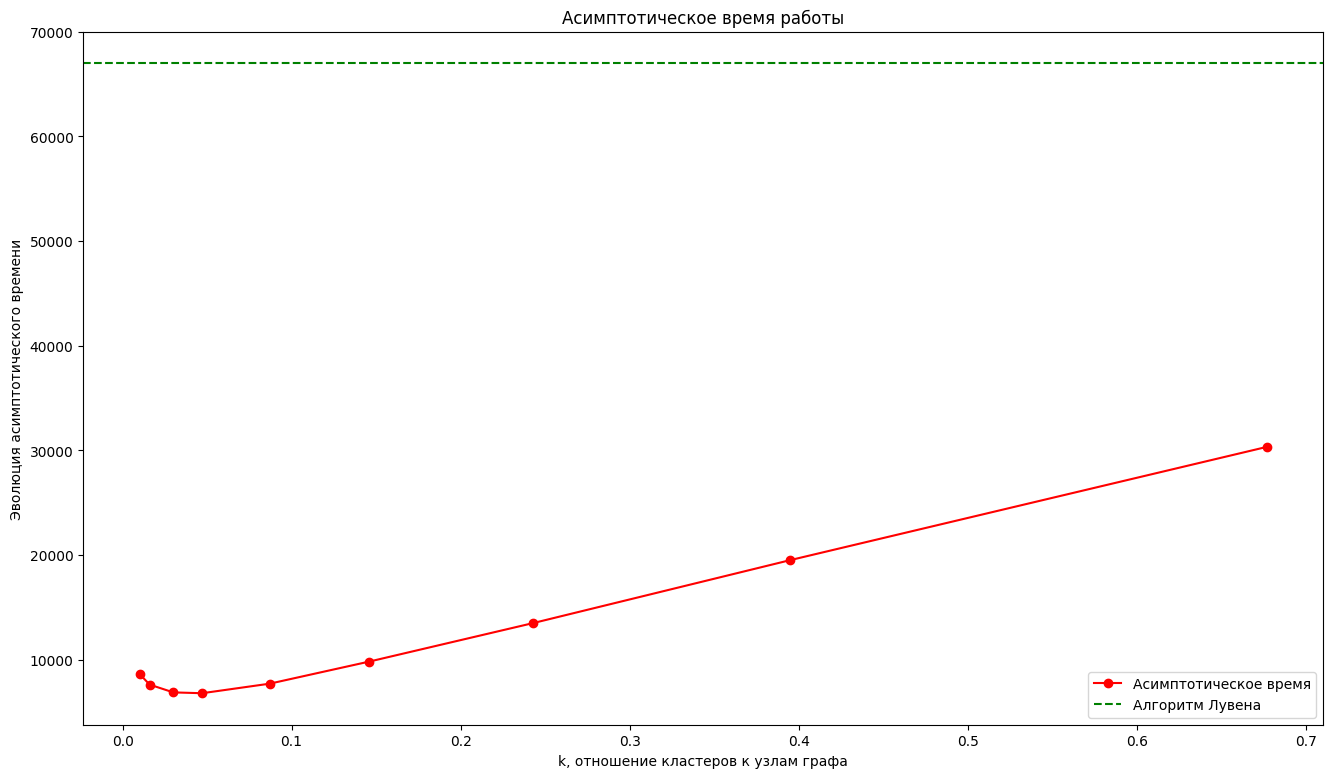

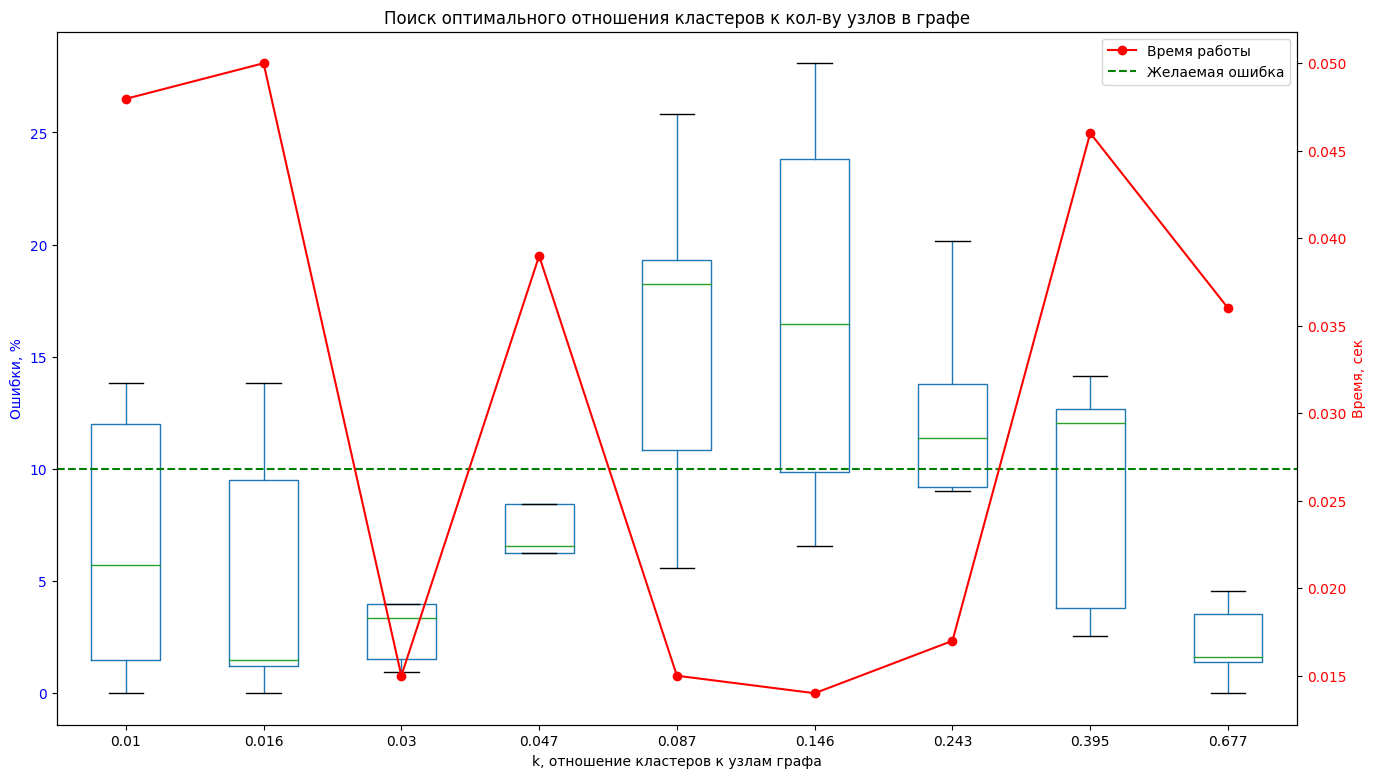

In [216]:
ids = list(result['city_ids'].apply(lambda x: 'R'+str(x)))                      # Тут все id для теста

for id in ids[:1]:
    try:
        H = download_graph(id, simplify=True)                                   # Загрузка графа
        resolutions, ks, v1, e1 = search_resolutions(H, k_max=0.6)              # Находим набор рабочих resolutions, ks, (v1, e1) для каждого графа
        visualisation(H, v1, e1)                                                # Визуализация времени работы по ks и формуле
        output, mistakes = test(H, resolutions, k=5, weight='length')           # Тест графа
        box_visualisation(H, output, mistakes)                                  # Визуализация ошибки boxplot`ом
    except Exception as e:
        print(f"Произошла ошибка при обработке графа с id {id}: {e}")
        continue